In [ ]:
#@title Importing Libraries
###############################################################################
############################# IMPORTING LIBRARIES #############################
###############################################################################
!pip install timm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from functools import partial
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model
from timm.models.vision_transformer import _cfg
import math
from PIL import Image
print('Pytorch version: ', torch.__version__)
print('GPU availability: ', torch.cuda.is_available())

In [ ]:
#@title Convert Binaries to images
os.mkdir("images")
os.mkdir("images/0")
os.mkdir("images/1")
# read binaries and convert to images
def row2image(row):
  img =list(row[1:1025]) 
  img = torch.Tensor(img).reshape(32,32)
  label = row[1025:1026]
  return img,label

dataset = '/content/raw_pe_images.csv'
nRowsRead = None # limit of rows

df_dataset = pd.read_csv(dataset, delimiter=',', nrows = nRowsRead)
df_dataset.dataframeName = 'malware_dataset'

images = list(); labels = list()
for i in range(1,51958):
    row = df_dataset.iloc[i]
    img,label = row2image(row)
    images.append(img)
    labels.append(label)
# save images
for i in range(49374,51957):
  im = Image.fromarray((images[i]).numpy())
  im = im.convert("L")
  im.save("/content/images/0/"+str(i)+".jpg")

for i in range(0,49373):
  im = Image.fromarray((images[i]).numpy())
  im = im.convert("L")
  im.save("/content/images/1/"+str(i)+".jpg")


# zip images and download them
!zip -r /content/images.zip /content/images
from google.colab import files
files.download("/content/images.zip")

# show random images
# images[0]
f, ax = plt.subplots(1,3, figsize=(5, 5))
ax[0].imshow((images[0].detach().cpu().numpy()))
ax[1].imshow((images[51200].detach().cpu().numpy()))
ax[2].imshow(images[51201].detach().cpu().numpy())

# !git clone https://github.com/whai362/PVT.git

In [ ]:
#@title Model
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0., linear=False):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.dwconv = DWConv(hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)
        self.linear = linear
        if self.linear:
            self.relu = nn.ReLU(inplace=True)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        x = self.fc1(x)
        if self.linear:
            x = self.relu(x)
        x = self.dwconv(x, H, W)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., sr_ratio=1, linear=False):
        super().__init__()
        assert dim % num_heads == 0, f"dim {dim} should be divided by num_heads {num_heads}."

        self.dim = dim
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.q = nn.Linear(dim, dim, bias=qkv_bias)
        self.kv = nn.Linear(dim, dim * 2, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        self.linear = linear
        self.sr_ratio = sr_ratio
        if not linear:
            if sr_ratio > 1:
                self.sr = nn.Conv2d(dim, dim, kernel_size=sr_ratio, stride=sr_ratio)
                self.norm = nn.LayerNorm(dim)
        else:
            self.pool = nn.AdaptiveAvgPool2d(7)
            self.sr = nn.Conv2d(dim, dim, kernel_size=1, stride=1)
            self.norm = nn.LayerNorm(dim)
            self.act = nn.GELU()
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        B, N, C = x.shape
        q = self.q(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)

        if not self.linear:
            if self.sr_ratio > 1:
                x_ = x.permute(0, 2, 1).reshape(B, C, H, W)
                x_ = self.sr(x_).reshape(B, C, -1).permute(0, 2, 1)
                x_ = self.norm(x_)
                kv = self.kv(x_).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
            else:
                kv = self.kv(x).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        else:
            x_ = x.permute(0, 2, 1).reshape(B, C, H, W)
            x_ = self.sr(self.pool(x_)).reshape(B, C, -1).permute(0, 2, 1)
            x_ = self.norm(x_)
            x_ = self.act(x_)
            kv = self.kv(x_).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        k, v = kv[0], kv[1]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)

        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, sr_ratio=1, linear=False):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim,
            num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
            attn_drop=attn_drop, proj_drop=drop, sr_ratio=sr_ratio, linear=linear)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop, linear=linear)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        x = x + self.drop_path(self.attn(self.norm1(x), H, W))
        x = x + self.drop_path(self.mlp(self.norm2(x), H, W))

        return x


class OverlapPatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=7, stride=4, in_chans=3, embed_dim=768):
        super().__init__()
        
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        
        assert max(patch_size) > stride, "Set larger patch_size than stride"
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.H, self.W = img_size[0] // stride, img_size[1] // stride
        self.num_patches = self.H * self.W
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
                              padding=(patch_size[0] // 2, patch_size[1] // 2))
        self.norm = nn.LayerNorm(embed_dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = self.proj(x)
        _, _, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)

        return x, H, W


class PyramidVisionTransformerV2(nn.Module):
    def __init__(self, img_size=224, patch_size=8, in_chans=1, num_classes=2, embed_dims=[64, 128, 256, 512],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[3, 4, 6, 3], sr_ratios=[8, 4, 2, 1], num_stages=4, linear=False):
        super().__init__()
        self.num_classes = num_classes
        self.depths = depths
        self.num_stages = num_stages

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule
        cur = 0

        for i in range(num_stages):
            patch_embed = OverlapPatchEmbed(img_size=img_size if i == 0 else img_size // (2 ** (i + 1)),
                                            patch_size=7 if i == 0 else 3,
                                            stride=4 if i == 0 else 2,
                                            in_chans=in_chans if i == 0 else embed_dims[i - 1],
                                            embed_dim=embed_dims[i])

            block = nn.ModuleList([Block(
                dim=embed_dims[i], num_heads=num_heads[i], mlp_ratio=mlp_ratios[i], qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + j], norm_layer=norm_layer,
                sr_ratio=sr_ratios[i], linear=linear)
                for j in range(depths[i])])
            norm = norm_layer(embed_dims[i])
            cur += depths[i]

            setattr(self, f"patch_embed{i + 1}", patch_embed)
            setattr(self, f"block{i + 1}", block)
            setattr(self, f"norm{i + 1}", norm)

        # classification head
        self.head = nn.Linear(embed_dims[3], num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def freeze_patch_emb(self):
        self.patch_embed1.requires_grad = False

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed1', 'pos_embed2', 'pos_embed3', 'pos_embed4', 'cls_token'}  # has pos_embed may be better

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        B = x.shape[0]

        for i in range(self.num_stages):
            patch_embed = getattr(self, f"patch_embed{i + 1}")
            block = getattr(self, f"block{i + 1}")
            norm = getattr(self, f"norm{i + 1}")
            x, H, W = patch_embed(x)
            for blk in block:
                x = blk(x, H, W)
            x = norm(x)
            if i != self.num_stages - 1:
                x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        return x.mean(dim=1)

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)

        return x


class DWConv(nn.Module):
    def __init__(self, dim=768):
        super(DWConv, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        x = x.transpose(1, 2).view(B, C, H, W)
        x = self.dwconv(x)
        x = x.flatten(2).transpose(1, 2)

        return x


def _conv_filter(state_dict, patch_size=16):
    """ convert patch embedding weight from manual patchify + linear proj to conv"""
    out_dict = {}
    for k, v in state_dict.items():
        if 'patch_embed.proj.weight' in k:
            v = v.reshape((v.shape[0], 3, patch_size, patch_size))
        out_dict[k] = v

    return out_dict


@register_model
def pvt_v2_b0(pretrained=False, **kwargs):
    model = PyramidVisionTransformerV2(
        patch_size=4, embed_dims=[32, 64, 160, 256], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4], qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[2, 2, 2, 2], sr_ratios=[8, 4, 2, 1],
        **kwargs)
    model.default_cfg = _cfg()

    return model


@register_model
def pvt_v2_b1(pretrained=False, **kwargs):
    model = PyramidVisionTransformerV2(
        patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4], qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[2, 2, 2, 2], sr_ratios=[8, 4, 2, 1],
        **kwargs)
    model.default_cfg = _cfg()

    return model


@register_model
def pvt_v2_b2(pretrained=False, **kwargs):
    model = PyramidVisionTransformerV2(
        patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4], qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 4, 6, 3], sr_ratios=[8, 4, 2, 1], **kwargs)
    model.default_cfg = _cfg()

    return model


@register_model
def pvt_v2_b3(pretrained=False, **kwargs):
    model = PyramidVisionTransformerV2(
        patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4], qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 4, 18, 3], sr_ratios=[8, 4, 2, 1],
        **kwargs)
    model.default_cfg = _cfg()

    return model


@register_model
def pvt_v2_b4(pretrained=False, **kwargs):
    model = PyramidVisionTransformerV2(
        patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4], qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 8, 27, 3], sr_ratios=[8, 4, 2, 1],
        **kwargs)
    model.default_cfg = _cfg()

    return model


@register_model
def pvt_v2_b5(pretrained=False, **kwargs):
    model = PyramidVisionTransformerV2(
        patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 6, 40, 3], sr_ratios=[8, 4, 2, 1],
        **kwargs)
    model.default_cfg = _cfg()

    return model


@register_model
def pvt_v2_b2_li(pretrained=False, **kwargs):
    model = PyramidVisionTransformerV2(
        patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4], qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 4, 6, 3], sr_ratios=[8, 4, 2, 1], linear=True, **kwargs)
    model.default_cfg = _cfg()

    return model


In [ ]:
#@title Defining dataset
###############################################################################
############################# DEFINING DATASET ################################
###############################################################################
class MalwareDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform

        self.images = list()

        for label in os.listdir(root):
            subdir = os.path.join(root, label)
            for im_name in os.listdir(subdir):
                im = plt.imread(os.path.join(subdir, im_name))
                self.images.append(im)

        self.dataset_size = len(self.images)

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, index):
        im = self.transform(self.images[index])
        if index > 49374:
          lab = 0; 
        else: 
          lab=1
        return im, lab

    def show_random(self, num_samples=8):
        indices = np.random.randint(0, len(self), [num_samples,])
        f, ax = plt.subplots(num_samples, 2, figsize=(10, 10))
        for i in range(num_samples):
            noised_im, im = self[indices[i]]
            ax[i, 0].imshow(im[0].numpy())
            ax[i, 1].imshow(noised_im[0].numpy())
        plt.show()

In [ ]:
################################################################
# Hyper parameters
################################################################
BATCH_SIZE = 128
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

################################################################
# Create training and testing dataset and show random examples
################################################################
trainval_set = MalwareDataset('/content/images', transform=transform)

################################################################
# As there is no validation set
# We split training dataset into training and validation sets
################################################################
train_size = int(0.6 * len(trainval_set))
val_size = int(0.2 * len(trainval_set))
test_size = len(trainval_set) - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(
    dataset=trainval_set,
    lengths=[train_size, val_size,test_size],
    generator=torch.Generator().manual_seed(42))

################################################################
# Print lengths of subsets
################################################################
print('Training set size: ', len(train_set))
print('Validation set size: ', len(val_set))
print('Testing set size: ', len(test_set))

################################################################
# Print lengths of subsets
################################################################
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=BATCH_SIZE,
    shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=BATCH_SIZE,
    shuffle=False)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=BATCH_SIZE,
    shuffle=False)

Training set size:  31173
Validation set size:  10391
Testing set size:  10392


In [ ]:
################################################################################
#########################  INSTANTIATING THE MODEL  ############################
################################################################################

model = PyramidVisionTransformerV2(
        patch_size=4, embed_dims=[32, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4], qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[2, 2, 2, 2], sr_ratios=[8, 4, 2, 1])
model.default_cfg = _cfg()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  
criterion = nn.CrossEntropyLoss()

In [ ]:
################################################################################
#############################  TRAINING  ########################################
################################################################################

avg_loss_list_val = list()
avg_loss_list_train = list()

BestState = model
model= model.cuda()
best_acc = 0
best_model = model

for epoch in range(100):
    well_pred = 0
    model.train()
    losses_train = list()
    acc_list_train = list()
    for batch_idx, (x, target) in enumerate(train_loader):
        optimizer.zero_grad()
        x, target = x.cuda(), target.cuda()
        out = model(x)
        _, pred_label = torch.max(out, 1)
        loss = criterion(out, target)
        losses_train.append(loss.item())
        loss.backward()
        optimizer.step()
        well_pred += (target == pred_label).sum()
    avg_loss_t = np.mean(losses_train)
    avg_acc_t = well_pred/len(train_set)
    avg_loss_list_train.append(avg_loss_t)
    

    # validation
    well_pred = 0
    losses_val = list()
    model.eval()
    acc_list_val = list()
    for batch_idx, (x, target) in enumerate(val_loader):
        x, target = x.cuda(), target.cuda()
        out = model(x)
        _, pred_label = torch.max(out, 1)
        loss = criterion(out,target)
        losses_val.append(loss.item())
        well_pred += (target == pred_label).sum()
    avg_loss_v = np.mean(losses_val)
    avg_loss_list_val.append(avg_loss_v)
    avg_acc_v = well_pred/len(val_set)

    print(f'==>>> epoch: {epoch}, train loss: {avg_loss_t:.6f}, val loss: {avg_loss_v:.6f}, train acc: {avg_acc_t:.6f}, val acc: {avg_acc_v:.6f}')

    if avg_acc_v > best_acc:
      best_loss = best_acc
      BestState = model.state_dict()
      torch.save(BestState, "Model.txt")


==>>> epoch: 0, train loss: 0.209832, val loss: 0.193683, train acc: 0.945658, val acc: 0.951400
==>>> epoch: 1, train loss: 0.184824, val loss: 0.173921, train acc: 0.949700, val acc: 0.951400
==>>> epoch: 2, train loss: 0.170468, val loss: 0.165122, train acc: 0.949700, val acc: 0.951400
==>>> epoch: 3, train loss: 0.160718, val loss: 0.167455, train acc: 0.949764, val acc: 0.951400
==>>> epoch: 4, train loss: 0.151447, val loss: 0.155299, train acc: 0.949989, val acc: 0.951400
==>>> epoch: 5, train loss: 0.139145, val loss: 0.168441, train acc: 0.951561, val acc: 0.950438
==>>> epoch: 6, train loss: 0.130785, val loss: 0.165177, train acc: 0.953614, val acc: 0.947647
==>>> epoch: 7, train loss: 0.113731, val loss: 0.163996, train acc: 0.957784, val acc: 0.947936
==>>> epoch: 8, train loss: 0.100990, val loss: 0.182638, train acc: 0.962628, val acc: 0.945241
==>>> epoch: 9, train loss: 0.084874, val loss: 0.199180, train acc: 0.969204, val acc: 0.933885
==>>> epoch: 10, train loss: 0

In [ ]:
################################################################################
#############################  TESTING  ########################################
################################################################################
# torch.save(BestState, "Model.txt")
checkpoint = torch.load("Model.txt")
model.load_state_dict(checkpoint)

test_loss = list()

model.eval()
acc_list_test = list()
losses_test = list()
for batch_idx, (x, target) in enumerate(test_loader):
      x, target = x.cuda(), target.cuda()
      out = model(x)
      _, pred_label = torch.max(out, 1)
      loss = criterion(out,target)
      losses_test.append(loss.item())
      batch_acc = (target == pred_label).sum() / ((target == pred_label).sum() + (target != pred_label).sum())
      acc_list_test.append(batch_acc.item())
avg_loss_test = np.mean(losses_test)
avg_acc_test = np.mean(acc_list_test)

print(f'TESTING RESULTS ==>, Test loss: {avg_loss_test:.6f}, Test acc: {avg_acc_test:.6f}')
       

TESTING RESULTS ==>, Test loss: 0.435017, Test acc: 0.949409


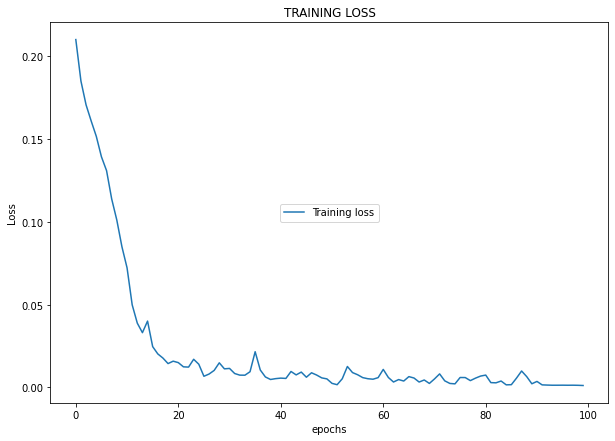

In [ ]:

plt.figure(figsize=(10,7)) 
plt.plot(avg_loss_list_train)
plt.title('TRAINING LOSS')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend([ ''], loc='center' )
plt.legend(['Training loss'], loc='center' )
